## Supplementary Figure 3

Comparing spherized normalization, subsampled scores, and median normalization in percent replicating scores

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
# The threshold indicats above the 95% percentile of carefully-controlled null distribution
threshold <- 0.05
plot_thresh <- -log10(threshold)

results_dir <- file.path("../1.Data-exploration/Profiles_level4/")

output_figure_base <- file.path("figures", "supplementary", "percent_replicating_all")
extensions <- c(".png", ".pdf")

In [3]:
# Load percent replicating with different input data
cell_painting_pr_spherized_pval <- load_percent_replicating_nonparametric_pvals(
    assay="cellpainting",
    results_dir=results_dir,
    cp_file_indicator=""
)

cell_painting_pr_nonspherized_pval <- load_percent_replicating_nonparametric_pvals(
    assay="cellpainting",
    results_dir=results_dir,
    cp_file_indicator="_nonspherized"
)

cell_painting_pr_subsample_pval <- load_percent_replicating_nonparametric_pvals(
    assay="cellpainting",
    results_dir=results_dir,
    cp_file_indicator="_subsample"
)

l1000_pval <- load_percent_replicating_nonparametric_pvals(
    assay="l1000",
    results_dir=results_dir,
    l1000_file_indicator=""
)

l1000_w_pval <- load_percent_replicating_nonparametric_pvals(
    assay="l1000",
    results_dir=results_dir,
    l1000_file_indicator="_w"
)

pr_pval_df <- dplyr::bind_rows(
    cell_painting_pr_nonspherized_pval,
    cell_painting_pr_spherized_pval,
    cell_painting_pr_subsample_pval,
    l1000_pval,
    l1000_w_pval,
)  %>%
    dplyr::mutate(
        pass_thresh = p_value < threshold,
        neg_log_10_p_val = -log10(p_value),
        assay_norm_group = paste0(assay, " (", normalization, ")\n", category)
    )

pr_pval_df$dose <- factor(pr_pval_df$dose, levels = dose_order)
pr_pval_df$neg_log_10_p_val[pr_pval_df$neg_log_10_p_val == Inf] = 3.5

recode_dataset_name <- c(
    "Cell Painting (spherized)\nall_data" = "Cell Painting spherized",
    "Cell Painting (spherized)\nsubsampled" = "Cell Painting subsampled",
    "Cell Painting (non_spherized)\nall_data" = "Cell Painting nonspherized",
    "L1000 (spherized)\nall_data" = "L1000 spherized",
    "L1000 (non_spherized)\nall_data" = "L1000 nonspherized"
)

pr_pval_df$assay_norm_group <- dplyr::recode(pr_pval_df$assay_norm_group, !!!recode_dataset_name)
pr_pval_df$assay_norm_group <- factor(pr_pval_df$assay_norm_group, levels = paste(recode_dataset_name))

print(dim(pr_pval_df))
head(pr_pval_df, 2)

[1] 37740    11


compound,no_of_replicates,dose,p_value,matching_score,assay,normalization,category,pass_thresh,neg_log_10_p_val,assay_norm_group
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<fct>
17-hydroxyprogesterone-caproate,5,0.04 uM,0.002,0.420116523,Cell Painting,non_spherized,all_data,TRUE,2.6989700,Cell Painting nonspherized
2-iminobiotin,5,0.04 uM,0.526,0.006742847,Cell Painting,non_spherized,all_data,FALSE,0.2790143,Cell Painting nonspherized


In [4]:
percent_replicating_df <- pr_pval_df %>%
    dplyr::group_by(assay_norm_group, dose) %>%
    dplyr::mutate(percent_replicating = paste0(100 * round((sum(pass_thresh) / length(pass_thresh)), 2), "%")) %>%
    dplyr::select(assay_norm_group, dose, percent_replicating) %>%
    dplyr::distinct()

head(percent_replicating_df, 2)

assay_norm_group,dose,percent_replicating
<fct>,<fct>,<chr>
Cell Painting nonspherized,0.04 uM,17%
Cell Painting nonspherized,0.12 uM,18%


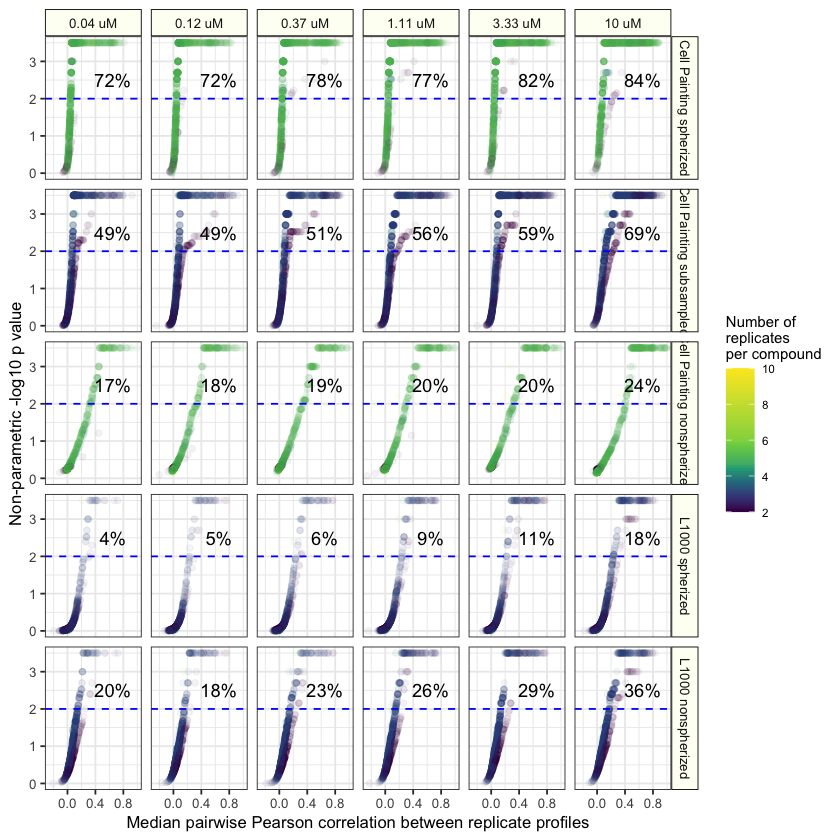

In [5]:
percent_replicating_all_gg <- (
    ggplot(pr_pval_df, aes(x = matching_score, y = neg_log_10_p_val))
    + geom_point(aes(color = no_of_replicates), alpha = 0.05)
    + geom_text(data = percent_replicating_df, aes(label = percent_replicating, x = 0.65, y = 2.5))
    + facet_grid("assay_norm_group~dose")
    + geom_hline(linetype = "dashed", color = "blue", yintercept = 2)
    + theme_bw()
    + figure_theme
    + scale_color_continuous(
        "Number of\nreplicates\nper compound",
        values = scales::rescale(c(0, 0.5, 1, 1.5, 2, 3, 6)),
        type = "viridis"
    )
    + xlab("Median pairwise Pearson correlation between replicate profiles")
    + ylab("Non-parametric -log10 p value")
)

percent_replicating_all_gg

In [6]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, percent_replicating_all_gg, base_width = 10, base_height = 8.5, dpi = 500)
}